<a href="https://colab.research.google.com/github/miYo-0/lunar_lander/blob/main/lunar_lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 - Import Packages
We'll make use of the following packages:

* `numpy` is a package for scientific computing in python.
* `deque` will be our data structure for our memory buffer.
* `namedtuple` will be used to store the experience tuples.
* The `gym` toolkit is a collection of environments that can be used to test reinforcement learning algorithms.
* `PIL.Image` and `pyvirtualdisplay` are needed to render the Lunar Lander environment.
* We will use several modules from the `tensorflow.keras` framework for building deep learning models.
* `utils` is a module that contains helper functions for this assignment. You do not need to modify the code in this file.


In [1]:
!pip install pyvirtualdisplay


In [2]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam


#utils module

In [3]:


import base64
import random
from itertools import zip_longest

import imageio
import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import tensorflow as tf
from statsmodels.iolib.table import SimpleTable
# import gym
from gym.wrappers.record_video import RecordVideo

# Rest of your code here...


class Utils:
    def __init__(self, SEED=0, MINIBATCH_SIZE=64, TAU=1e-3, E_DECAY=0.995, E_MIN=0.01):
        self.SEED = SEED    # seed for pseudo-random number generator
        self.MINIBATCH_SIZE = MINIBATCH_SIZE   # mini-batch size
        self.TAU = TAU    # soft update parameter
        self.E_DECAY = E_DECAY    # ε decay rate for ε-greedy policy
        self.E_MIN = E_MIN    # minimum ε value for ε-greedy policy
        random.seed(SEED)

    def get_experiences(self,memory_buffer):
        experiences = random.sample(memory_buffer, k=self.MINIBATCH_SIZE)
        states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
        actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
        rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
        next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
        done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                        dtype=tf.float32)
        return (states, actions, rewards, next_states, done_vals)


    def check_update_conditions(self,t, num_steps_upd, memory_buffer):
        if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > self.MINIBATCH_SIZE:
            return True
        else:
            return False


    def get_new_eps(self,epsilon):
        return max(self.E_MIN, self.E_DECAY*epsilon)


    def get_action(self,q_values, epsilon=0):   ##self modified
        if random.random() > epsilon:
            return np.argmax(q_values.numpy()[0])
        else:
            return random.choice(np.arange(4))


    def update_target_network(self,q_network, target_q_network):
        for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
            target_weights.assign(self.TAU * q_net_weights + (1.0 - self.TAU) * target_weights)


    def plot_history(reward_history, rolling_window=20, lower_limit=None,
                    upper_limit=None, plot_rw=True, plot_rm=True):

        if lower_limit is None or upper_limit is None:
            rh = reward_history
            xs = [x for x in range(len(reward_history))]
        else:
            rh = reward_history[lower_limit:upper_limit]
            xs = [x for x in range(lower_limit,upper_limit)]

        df = pd.DataFrame(rh)
        rollingMean = df.rolling(rolling_window).mean()

        plt.figure(figsize=(10,7), facecolor='white')

        if plot_rw:
            plt.plot(xs, rh, linewidth=1, color='cyan')
        if plot_rm:
            plt.plot(xs, rollingMean, linewidth=2, color='magenta')

        text_color = 'black'

        ax = plt.gca()
        ax.set_facecolor('black')
        plt.grid()
    #     plt.title("Total Point History", color=text_color, fontsize=40)
        plt.xlabel('Episode', color=text_color, fontsize=30)
        plt.ylabel('Total Points', color=text_color, fontsize=30)
        yNumFmt = mticker.StrMethodFormatter('{x:,}')
        ax.yaxis.set_major_formatter(yNumFmt)
        ax.tick_params(axis='x', colors=text_color)
        ax.tick_params(axis='y', colors=text_color)
        plt.show()


    def display_table(initial_state, action, next_state, reward, done):

        action_labels = ["Do nothing", "Fire right engine", "Fire main engine", "Fire left engine"]

        # Do not use column headers
        column_headers = None

        with np.printoptions(formatter={'float': '{:.3f}'.format}):
            table_info = [("Initial State:", [f"{initial_state}"]),
                          ("Action:", [f"{action_labels[action]}"]),
                          ("Next State:", [f"{next_state}"]),
                          ("Reward Received:", [f"{reward:.3f}"]),
                          ("Episode Terminated:", [f"{done}"])]

        # Generate table
        row_labels, data = zip_longest(*table_info)
        table = SimpleTable(data, column_headers, row_labels)

        return table


    def embed_mp4(filename):
        """Embeds an mp4 file in the notebook."""
        video = open(filename,'rb').read()
        b64 = base64.b64encode(video)
        tag = '''
        <video width="840" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
        Your browser does not support the video tag.
        </video>'''.format(b64.decode())
        return IPython.display.HTML(tag)


    def create_video(filename, env, q_network, fps=30):
        with imageio.get_writer(filename, fps=fps) as video:
            done = False
            state = env.reset()
            frame = env.render(mode="rgb_array")
            video.append_data(frame)
            while not done:
                state = np.expand_dims(state, axis=0)
                q_values = q_network(state)
                action = np.argmax(q_values.numpy()[0])
                state, _, done, _ = env.step(action)
                frame = env.render(mode="rgb_array")
                video.append_data(frame)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
!pip install gym


In [5]:
utils = Utils()

In [6]:
# Set up a virtual display to render the Lunar Lander environment.
# Display(visible=0, size=(840, 480)).start();

# Set the random seed for TensorFlow
tf.random.set_seed(utils.SEED)

# Hyperparameters

In [7]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

# The Lunar Lander Environment
In this notebook we will be using `OpenAI's Gym Library`. The Gym library provides a wide variety of environments for reinforcement learning. To put it simply, an environment represents a problem or task to be solved. In this notebook, we will try to solve the Lunar Lander environment using reinforcement learning.

The goal of the Lunar Lander environment is to land the lunar lander safely on the landing pad on the surface of the moon. The landing pad is designated by two flag poles and it is always at coordinates (0,0) but the lander is also allowed to land outside of the landing pad. The lander starts at the top center of the environment with a random initial force applied to its center of mass and has infinite fuel. The environment is considered solved if you get 200 points.

In [8]:
envs = gym.envs.registry.all()
env_ids = [env.id for env in envs]
print(env_ids)


['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4']


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [9]:
!pip install swig
!pip install box2d-py


In [10]:
env = gym.make('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


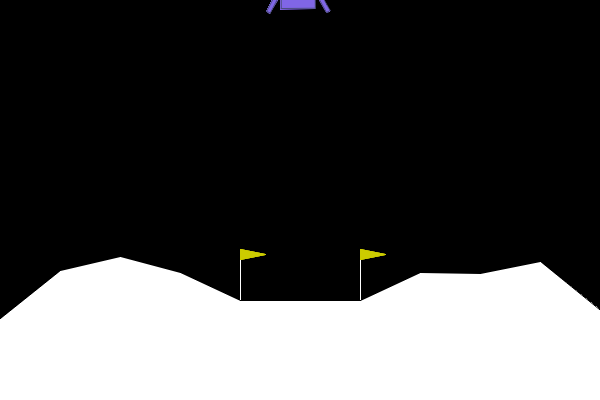

In [11]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In order to build our neural network later on we need to know the size of the state vector and the number of valid actions. We can get this information from our environment by using the .observation_space.shape and action_space.n methods, respectively.

In [12]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


# Exploring the Environment's Dynamics

In [13]:
# Reset the environment and get the initial state.
initial_state = env.reset()

In this environment the agent has four discrete actions available and we specify them in code by using their corresponding numerical value:

* Do nothing = 0
* Fire right engine = 1
* Fire main engine = 2
* Fire left engine = 3

In [14]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)

Initial State: [0.007 1.410 0.702 -0.050 -0.008 -0.159 0.000 0.000]
Action: 0
Next State: [0.014 1.408 0.701 -0.075 -0.016 -0.157 0.000 0.000]
Reward Received: -0.7552050194562412
Episode Terminated: False
Info: {}


# Deep Q-Learning

In the Deep Q-Learning, we solve this problem by using a neural network to estimate the action-value function `Q(s,a)~ Q*(s,a)`. We call this neural network a Q-Network and it can be trained by adjusting its weights at each iteration to minimize the mean-squared error in the Bellman equation.

Unfortunately, using neural networks in reinforcement learning to estimate action-value functions has proven to be highly unstable. Luckily, there's a couple of techniques that can be employed to avoid instabilities. These techniques consist of using a ***Target Network*** and ***Experience Replay***.

In [15]:
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

# ALPHA defined in hyperparameter section
optimizer = Adam(learning_rate=ALPHA)

# Experience Replay

In [16]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


By using experience replay we avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

# Deep Q-Learning Algorithm with Experience Replay

In [17]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss
    loss = MSE(y_targets, q_values)

    return loss

In [18]:
@tf.function  ## @tf.function decorator to increase performance
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.

    """

    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

# Train the agent

In [19]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -171.17
Episode 200 | Total point average of the last 100 episodes: -84.35
Episode 300 | Total point average of the last 100 episodes: -58.37
Episode 400 | Total point average of the last 100 episodes: 11.34
Episode 500 | Total point average of the last 100 episodes: 85.60
Episode 600 | Total point average of the last 100 episodes: 173.96
Episode 634 | Total point average of the last 100 episodes: 199.48

Episode 635 | Total point average of the last 100 episodes: 200.32

Environment solved in 635 episodes!

Total Runtime: 1924.35 s (32.07 min)


# Ploting the point history to see how our agent improved during training

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


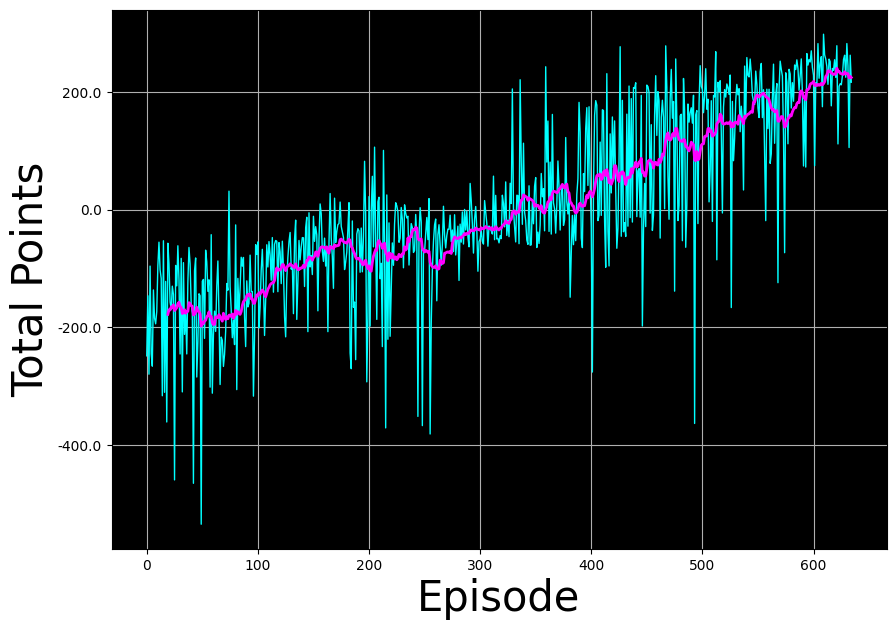

In [26]:
# Plot the point history
Utils.plot_history(total_point_history)

# See the Trained Agent In Action

In [27]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [68]:
# filename = "./videos/lunar_lander.mp4"

filename = "/content/videos/lunar_lander.mp4/rl-video-episode-0.mp4"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
Utils.create_video(filename, env, q_network)
Utils.embed_mp4(filename)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
